# Scattered points, a grid of bases
This workbook is a first attempt at constructing a simulation of a stochastic dynamical system, with an accompanying estimation of the Perron-Frobenius operator.

In [1]:
include("functions.jl");

## Setting up the dynamics
The state space $X$ of our dynamical system will be the flat torus $\mathbb{T}^2$, represented by the square $[0, 2\pi] \times [0, 2\pi]$.

In [2]:
range = 2π;

For most numerical work, we will require a fine reference grid of points.

In [3]:
grid_size = 100;
n_gridpoints = grid_size ^ 2;
grid = creategrid(0, range, grid_size);

### An initial density
We will define an initial uniform density $f_0 (x, y)$ on this state space.

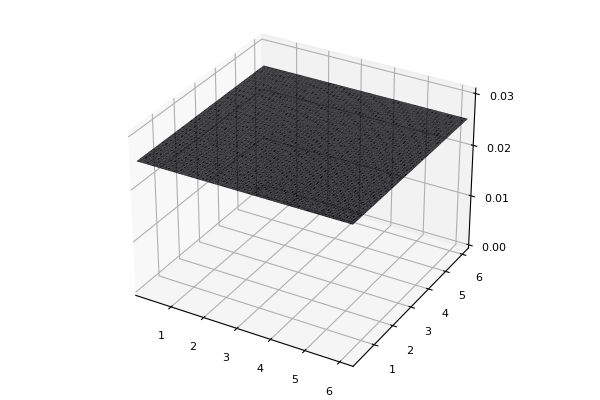

In [4]:
f0s = [f(grid[n,:], range) for n in 1:n_gridpoints];
surface(grid[:,1], grid[:,2], f0s, legend=false, markersize=1)
zlims!(0, 1.2 * (1/(range^2)))

From this initial uniform density $f_0$, we will need to draw a sample.

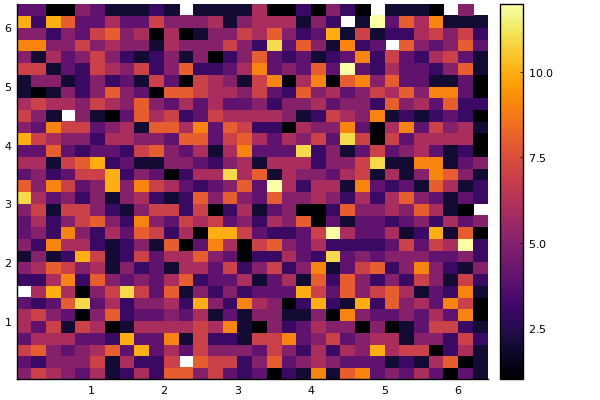

In [5]:
sample_size = 5000;
s = sampledist(sample_size, range);

histogram2d(s[:,1], s[:,2], bins=50)

### A dynamical map
The particular map $S: \mathbb{T}^2 \to \mathbb{T}^2$ chosen to introduce the dynamics is the standard map, or Chirikov–Taylor map, given by
$$
S ([x , y]) := \begin{bmatrix} x + y \\ y + a \sin ( x + y) \end{bmatrix} \mod 2\pi
$$
where $a$ is a parameter which controls the amount of chaos. For the moment we take this to be $a=6$. This map is defined in the function ```S``` which can then be iterated forward across timesteps via ```S_forward```.

In [6]:
X = s;
Y = S(X);

We can easily compare the initial density $f_0$ with a naive estimate of a limiting density $f_*$ by computing the latter with a big value for `S_forward`.

In [7]:
fstar = S_forward(s, S, 100);

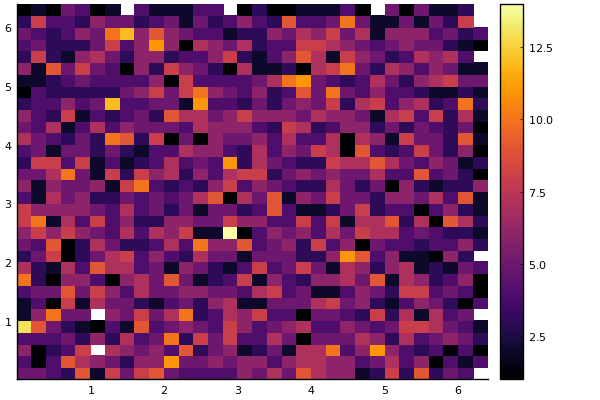

In [8]:
histogram2d(fstar[:,1], fstar[:,2], bins=50)

In this case, the limiting density is precisely the same constant function we started with, and it looks like we have a similatly uniform distribution for `fstar`.

## Estimating the Perron-Frobenius operator
Having established a model for the dynamics, next we want to estimate the Perron-Frobenius operator,
$$
\mathcal{P} : L^1(X) \to L^1(X) .
$$
In particular, we are interested in this operator in the stochastic setting, which can be characterised by the presence of a transition kernel $k(\cdot, \cdot)$. This can be written as
$$
 \mathcal{P} f(y) = \int_X k(S(x), y ) f(x) \, \mathrm{d}x
$$
where $k(x, y) = \phi(x-y)$. 

To estimate this infinite-dimensional operator, we will need to work in a finite-dimensional subspace of $L^1(X)$, which we call $H$. Since $\mathcal{P}$ is linear, it will then suffice to compute its action on a basis. This will allow us to construct a square matrix $P$, which we will take to be our estimate of $\mathcal{P}$, in that $P(H) = \mathcal{P}(H)$.

### A finite basis
To compute $P$, we first must define a finite basis $H$ for $L^1(X)$. For the moment, we take this basis to be a uniform grid of $B$ Gaussian functions $\left\{ \varphi_i \right\}_{i=1}^B$ defined on the state space $X$. These will be of the form
$$
\varphi_i (x) = \phi ( x - z_i ) := \exp \left( - \frac{\| x - z_i \|^2}{\epsilon^2} \right)
$$
where the $z_i$ denote the centres of each function and $\epsilon$ is some bandwidth parameter. The set $\{\varphi_i \}_{i=1}^B$ is then taken as a basis for $H$.
$$
H = \operatorname{span} \left( \{\varphi_i \}_{i=1}^B \right)
$$

In [9]:
basis_grid_size = 20;
n_bases = basis_grid_size ^ 2;
basis_locs = creategrid(0, range, basis_grid_size);

The value chosen for $\epsilon$ is an exogenous parameter, and will clearly influence the structure of $H$. Following XXXX, we will set it equal to the average nearest-neighbour distance, which is simply the grid interval size. This will also affect the value of the integral $\int_X \varphi_i (x) \, \mathrm{d}x = c = \pi \epsilon^2$.

In [10]:
ϵ = range / basis_grid_size;
c = π * ϵ^2;

Having defined this basis $\{\varphi_i \}_{i=1}^B$, we can get a sense of its shape by evaluating all grid points against each $\varphi_i$ and summing the results.

In [11]:
basis_evaluation_matrix = Array{Float64}(undef, n_gridpoints, n_bases);
for b in 1:n_bases
    for n in 1:n_gridpoints
        basis_evaluation_matrix[n, b] = φ(grid[n, :], basis_locs[b, :], ϵ);
    end
end

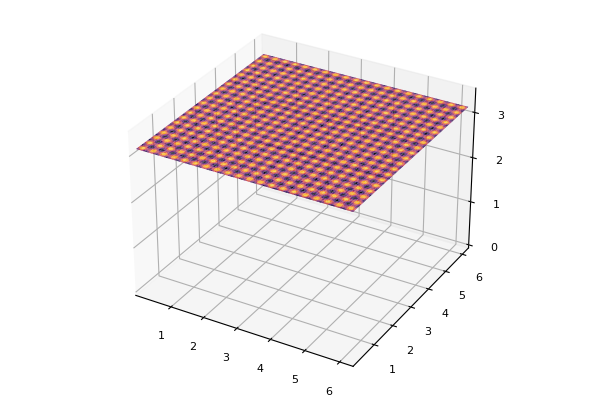

In [12]:
basis_surface = sum(basis_evaluation_matrix, dims=2)[:];
surface(grid[:,1], grid[:,2], basis_surface; legend=false)
zlims!(0,maximum(basis_surface)*1.1)

This is the 'basis surface' of the constructed subspace $H$, which can be used to approximate any function in $L^1(X)$. To do so, we just take a linear combination of the basis functions. For example:

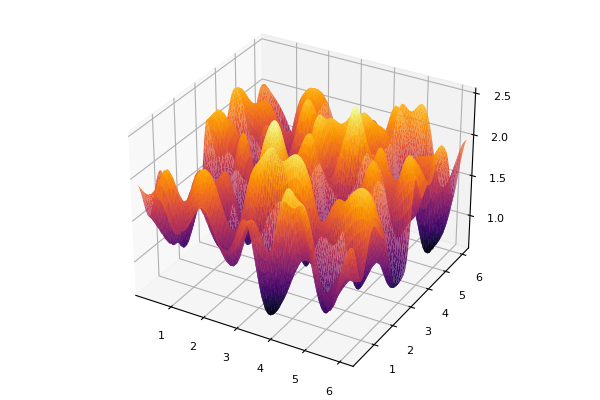

In [13]:
β = rand(n_bases);
test_surface = basis_combination(grid, basis_locs, φ, ϵ, β);
surface(grid[:,1], grid[:,2], test_surface; legend=false)

We will also be interested in the best possible approximation of the known invariant density for the standard map, which is the constant function. This can be solved for using least squares, but since the basis functions form a uniform grid, it is clear that all scalars $\{ \eta_i \}_{i=1}^B$ will just be equally weighted.

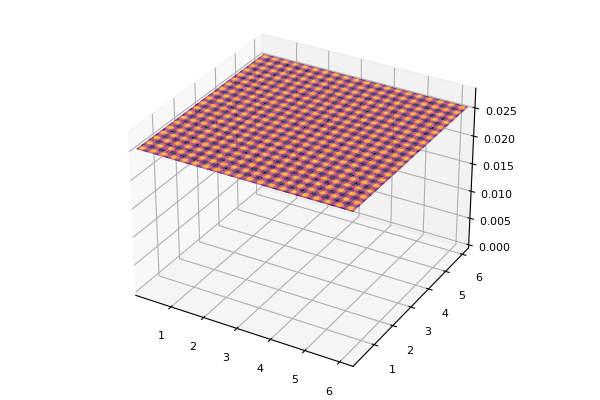

In [14]:
integral = (2π)^2 * sum(basis_surface) / n_gridpoints;
η = ones(n_bases) / integral;
invariant_density_surface = basis_combination(grid, basis_locs, φ, ϵ, η);
surface(grid[:,1], grid[:,2], invariant_density_surface; legend=false)
zlims!(0,maximum(invariant_density_surface)*1.1)

### Numerical integration
So we have chosen the subspace $H$. In order to estimate the integral
$$
    \mathcal{P} f(y) = \int_X k (S(x), y) f(x) \, \mathrm{d}x ,
$$
for some arbitrary function $f\in H$ we will also need an approximate Lebesgue measure, with respect to $\mathrm{d}x$. We will do this with a weighted combination of $\delta$-measures at each $x_n$; that is, we estimate Lebesgue measure as $\sum_{n=1}^N w_n \delta_{x_n}$. How do we choose the weights $w_n$? That is, how much weight should we assign to each point $x_n$? One strategy would be to estimate a whole lot of known integrals, for functions defined across the phase space, and then take some kind of average of all the weights that this process spits out. This can be achieved by introducing a class of test functions $\{ \psi_k (x) \}_{k=1}^K$, where each $\psi_k(x) = \phi(x - z_k)$ and the $z_k$ are location parameters for each function. We can then require that
$$
\sum_{n=1}^N w_n \psi_k (x_n) \approx \int_X \psi_k (x) \, \mathrm{d} x = c = \pi \epsilon^2
$$
simultaneously for each $k=1, \ldots, K$. In matrix form, this means solving the optimisation problem
\begin{equation}
\begin{bmatrix} \psi_1(x_1) & \cdots & \psi_1(x_N) \\ \vdots & & \\
\psi_K (x_1) &  & \psi_K(x_N) \end{bmatrix} \begin{bmatrix} w_1 \\ \vdots \\ w_N \end{bmatrix} \approx \begin{bmatrix} c \\ \vdots \\ c \end{bmatrix} . 
\label{matrix}
\end{equation}
We can formulate this as a nonnegative least squares optimisation problem
\begin{align*} & \min_{w \in \mathbb{R}^N} \| \Psi w - C \|_2^2 \\
&\text{s.t.} \ w_n \geq 0 \quad n =1, \ldots, N
\end{align*}
where $\Psi$, $w$ and $C$ are identified with the respective matrices and vectors in the previous display equation. We can anticipate that this will cause a lot of the $w_n$ to be set to zero. To prevent this, we will penalise values of $w_n$ that are far away from the expected uniform weighting, $\bar{w} = \frac{m(X)}{N}$. Hence the optimisation problem becomes
\begin{align*} & \min_{w \in \mathbb{R}^N} \| \Psi w - C \|_2^2 + \kappa \| w - \bar{W} \|_2^2\\
&\text{s.t.} \ w_n \geq 0 \quad n =1, \ldots, N
\end{align*}
where $\kappa \in \mathbb{R}$ is some penalty parameter.

But what about the locations for these test functions $\{ \psi \}_{k=1}^K$? The most reasonable thing to do would be to space them on a grid, since this will mean we have nice uniform coverage of the phase space $X$. But of course, we have already defined a grid of functions $\phi$: the basis, $\{ \varphi_i \}_{i=1}^B$. So why not use them? That is, why not identify each $\varphi_i = \psi_k$? To calculate the matrix $\Psi$, we then simply evaluate every test/basis function against every data point.

In [15]:
Ψ = evaluate_funcs(s, basis_locs, φ, ϵ);

We can also recycle the same value of $\epsilon$ for these test functions, since they are on the same grid as the basis functions. With two more vectors, we are ready for the optimisation procedure.

In [16]:
C = c * ones(n_bases);
w_av = (range^2) / sample_size;

In [17]:
w, residual, objvalue = nnlsq_pen(Ψ, C, w_av, 0.00);

Academic license - for non-commercial use only - expires 2021-08-05
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads
Optimize a model with 400 rows, 5400 columns and 470488 nonzeros
Model fingerprint: 0xe17972d1
Model has 400 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e-13, 1e+00]
  Objective range  [0e+00, 0e+00]
  QObjective range [2e+00, 2e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 3e-01]
Presolve time: 0.16s
Presolved: 400 rows, 5400 columns, 470488 nonzeros
Presolved model has 400 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 7.051e+04
 Factor NZ  : 8.020e+04 (roughly 3 MBytes of memory)
 Factor Ops : 2.141e+07 (less than 1 second per iteration)
 Threads    : 2

                  Objective                Residual
Iter       Primal        

The weights should sum to close to $(2\pi)^2$, since this is the area of the state space.

In [18]:
println("Total sum of weights: $(sum(w))")
println("Area of state space: $((2π)^2)")
println("Ratio: $(sum(w) / (2π)^2)")

Total sum of weights: 39.4784622879882
Area of state space: 39.47841760435743
Ratio: 1.0000011318495898


We would also expect that the average weight is close to an equal tesselation of the state space, since all the data points are uniformly distributed.

In [19]:
println("Average weight: $(mean(w))")
println("Equal tesselation size: $(w_av)")

Average weight: 0.00789569245759764
Equal tesselation size: 0.007895683520871487


We might expect that since the sample points are uniformly distributed, the weights would be almost all equal. This is largely true.

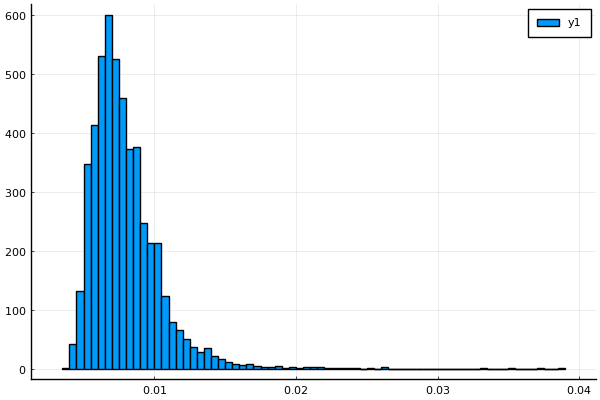

In [20]:
histogram(w)

With these weights, we can now compute the integral $\mathcal{P}f(x)$. In particular, we are interested in computing $\mathcal{P}\varphi_i(x)$ for all $B$ basis functions, since this will clearly suffice in constructing $P$.
$$
\mathcal{P}\varphi_i(y) = \int_X k (S(x), y) \varphi_i(x) \, \mathrm{d}x
$$
For convenience, we will use the stochastic kernel $k (x, y) = \rho (x - y) = \frac{1}{c} \phi (x-y)$. Hence under the image points, $k(S(x) , y )$ becomes in effect an image of the basis functions, with $k(S(x_m), y) = \frac{1}{c} \varphi_{y_m}$. So our estimation of the above integral becomes the discrete sum
$$
\mathcal{P}\varphi_i(y) \approx \sum_{m=1}^N \frac{1}{c} \left( w_m \cdot \varphi_i (x_m) \right)  \varphi_{y_m} (y)
$$

Hence we can write each of the basis functions $\varphi_i$ as a linear combination of basis functions centered at the image points, $\{ \varphi_{y_n} \}_{n=1}^N$. But we obviously want to be able to write each $\mathcal{P} \varphi_i$ as just a linear combination of the $\varphi_i$. To do this, we will need to 'project' back onto the original subspace $H$ by writing each $\varphi_{y_m}$ itself as a linear combination of the $\varphi_i$.
$$
 \varphi_{y_m} (y) = \sum_{i=1}^B \gamma_i \varphi_i (y)
$$

Where do the weights $\gamma_i$ come from? We will need to calculate them according to a procedure suggested by Ding, Eifler, and Rhee. This says that
$$
\varphi_{y_m} (y) \approx Q \varphi_{y_m} (y) = \sum_{j=1}^B \left( \int_{V_j} c_j \varphi_{y_m} \right) \varphi_j (y) .
$$
Each of these integrals is computed over a Voronoi tesselation of the state space $X$, such that each $V_j$ corresponds to a particular basis function $\varphi_j$. What about the weights $c_j$? Per the same source, these must satisfy
\begin{align*}
    \sum_{j=1}^N \langle \varphi_j , \mathbb{1} \rangle c_j \mathbb{1}_{V_j} &= \mathbb{1} \\
    \sum_{j=1}^N C \cdot c_j \mathbb{1}_{V_j} &= \mathbb{1} \\
    \therefore c_j &= \frac{1}{c}
\end{align*}
so will be uniform across the integrals.

For the sake of computation, `integrate_phiy` is just used to compute the $B$ integral values for each image point, omitting the $c_j$. The results are stored in the matrix $\Xi$.

In [21]:
Ξ = integrate_phiy(Y, basis_locs, range, 100, φ, ϵ);

We will also need an evaluation matrix of all sample points against all basis functions, which we denote $\Phi$.

In [22]:
Φ = evaluate_funcs(X, basis_locs, φ, ϵ);

This is now everything we need to compute the matrix $P$.

In [23]:
P = construct_P(w, Φ, Ξ, c);

In [24]:
display(P)

400×400 Matrix{Float64}:
 0.0373111   0.0258622   0.00589688   …  0.00892075   0.0236564
 0.0253151   0.0187131   0.00476433      0.00867826   0.0232815
 0.0147619   0.0151766   0.00538629      0.00505687   0.0153584
 0.0112492   0.0132026   0.00516169      0.00226268   0.00784612
 0.00761001  0.0111614   0.00612087      0.0017005    0.0045571
 0.00663766  0.0122625   0.00658257   …  0.00206428   0.00250369
 0.00455133  0.00741222  0.00368449      0.00273523   0.00223321
 0.00252848  0.00360537  0.00229171      0.00326544   0.00167015
 0.00156483  0.00249291  0.00264474      0.00265857   0.000882858
 0.002831    0.00196353  0.00223825      0.00395725   0.00160113
 0.00594972  0.00130807  0.000945141  …  0.00638778   0.00363529
 0.00669717  0.00125568  0.00072141      0.0120442    0.00728435
 0.00797748  0.00144494  0.000439582     0.0198536    0.0145392
 ⋮                                    ⋱               
 0.0081162   0.0231392   0.0246151       0.000685072  0.00443646
 0.00462944  0

## Checking the results
Now that we have an estimate of $P$, we can start appraising it.

### Plotting the spectrum
We expect that $P$ should have a leading unit eigenvalue, and all the remaining eigenvalues should have modulus less than one.

In [25]:
λ, Λ = ordered_eigendecomp(P);

In [26]:
display(λ[1])

1.0000000000002933 + 0.0im

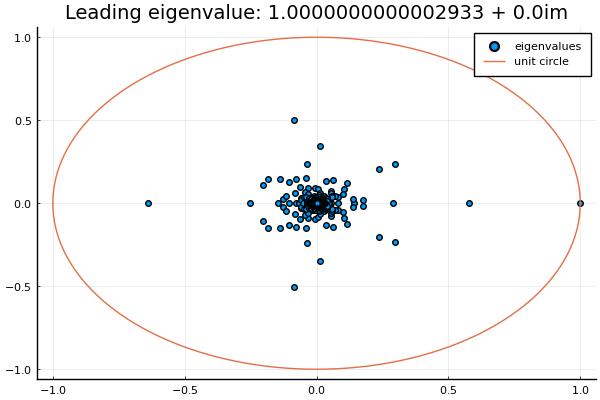

In [27]:
u, v = real.(λ), imag.(λ);
xc, yc = cos.(LinRange(0, 2π, 500)), sin.(LinRange(0, 2π, 500));

scatter(u, v, label="eigenvalues")
plot!(xc, yc, label="unit circle")
title!("Leading eigenvalue: $(λ[1])")

Happily, this does indeed appear to be the case.

### Row stochasticity
We also expect that the estimate should be row-stochastic.

In [28]:
row_sums = sum(P, dims=2)[:];
col_sums = sum(P, dims=1)[:];

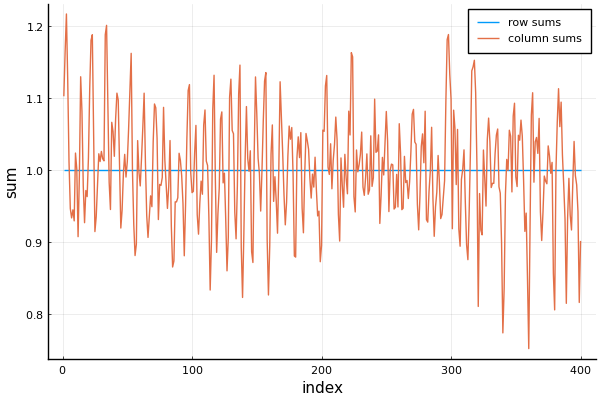

In [29]:
plot(row_sums, label="row sums")
plot!(col_sums, label="column sums")
xlabel!("index")
ylabel!("sum")

Row sums are indeed constant; this value is of course the leading unit eigenvalue.

### Invariant density
We know that the leading eigenvector will specify the linear combination of basis functions which represents the invariant density. We may need to take the absolute value, since the solutions to the eigenproblem may flip the signs.

In [30]:
α = real.(Λ[:,1]);
α = abs.(α);

In [31]:
display(α)

400-element Vector{Float64}:
 0.04999999999999015
 0.05000000000002103
 0.04999999999998539
 0.05000000000003424
 0.04999999999994687
 0.05000000000001774
 0.04999999999996608
 0.050000000000010425
 0.04999999999998595
 0.050000000000058
 0.04999999999995004
 0.05000000000008188
 0.0499999999999453
 ⋮
 0.05000000000000044
 0.04999999999995233
 0.05000000000005242
 0.049999999999912476
 0.0500000000000744
 0.049999999999924216
 0.050000000000048894
 0.04999999999996137
 0.05000000000001567
 0.05000000000000605
 0.049999999999999045
 0.05000000000003557

In [32]:
invariant_density = basis_combination(grid, basis_locs, φ, ϵ, α);

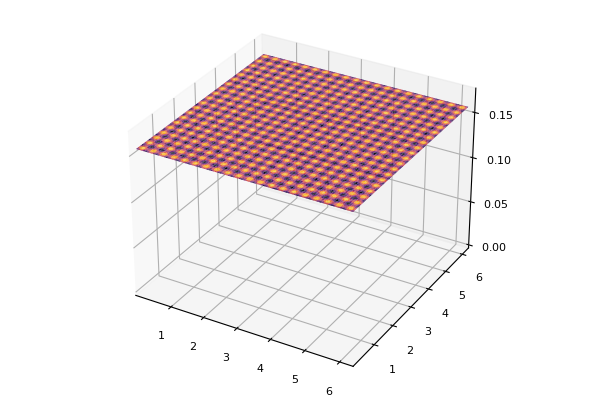

In [33]:
surface(grid[:,1], grid[:,2], invariant_density; legend=false)
zlims!(0, maximum(invariant_density)*1.1)

This looks pretty flat, which is good, since we know that the invariant density under the standard map is just the constant function. But this intuition can be quantified by computing the $L^1$, $L^2$ and $L^\infty$ norms of the difference between our estimated invariant density, denoted $\hat{f}^*$, and the known true invariant density, which we denote $f^*$. Or rather, we can compare $\hat{f}^*$ with the best possible representation of $f^*$ with respect to the basis we have chosen, which we denote $f^\dagger$. So we are interested in the quantities
\begin{align*}
\| \hat{f}^* - f^\dagger \|_1 &= \int_X | \hat{f}(x) - f^\dagger (x) | \ \mathrm{d}x \\
\| \hat{f}^* - f^\dagger \|_2 &= \left( \int_X | \hat{f}(x) - f^\dagger (x) |^2  \mathrm{d}x \right)^\frac{1}{2}\\
\| \hat{f}^* - f^\dagger \|_\infty &= \sup | \hat{f}(x) - f^\dagger (x) | 
\end{align*}

Of course, since any two functions $f,g \in H$ can be written as linear combinations of basis elements,
\begin{align*}
    f(x) &= \sum_{i=1}^B \alpha_i \varphi_i (x) \\
    g(x) &= \sum_{i=1}^B \beta_i \varphi_i (x)
\end{align*}
it follows that
\begin{align*}
f - g &= \sum_{i=1}^B \alpha_i \varphi_i - \sum_{i=1}^B \beta_i \varphi_i \\
&= \sum_{i=1}^B (\alpha_i - \beta_i) \varphi_i
\end{align*}
and hence
\begin{align*}
\int_X f - g &= \int \sum_{i=1}^B (\alpha_i - \beta_i) \varphi_i \\
&= \sum_{i=1}^B (\alpha_i - \beta_i) \int_X \varphi_i \\
&= c \sum_{i=1}^B (\alpha_i - \beta_i)
\end{align*}
so we are really just interested in the differences between the scalars.

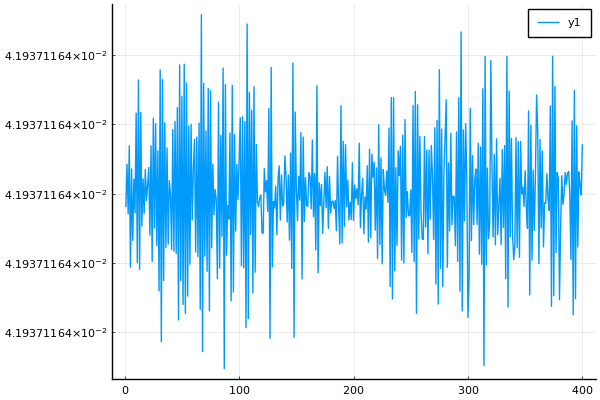

In [34]:
plot(abs.(α - η))

In [35]:
l1 = Lp_norm(α - η, c; p="one");
l∞ = Lp_norm(α - η, c; p="∞");

println("L1 norm of difference: $l1")
println("L∞ norm of difference: $l∞")

L1 norm of difference: 5.201255336059963
L∞ norm of difference: 0.04193711639182922


### Integral preservation and evolving forward a density
Last, we try directly evolving forward a density using $P$, and use this as an occasion to check that indeed preserves integrals. We start with a random density function $f \in H$, where $f = \sum_{i=1}^B \beta_i \varphi_i$.

In [36]:
β = rand(n_bases)
initial_density = basis_combination(grid, basis_locs, φ, ϵ, β);
integral = (2π)^2 * sum(initial_density) / n_gridpoints;
println("Estimate of initial integral: $integral")

β = β / integral;
initial_density = basis_combination(grid, basis_locs, φ, ϵ, β);
integral = (2π)^2 * sum(initial_density) / n_gridpoints;
println("Estimate of normalised integral: $integral")

Estimate of initial integral: 64.60527845017046
Estimate of normalised integral: 1.0


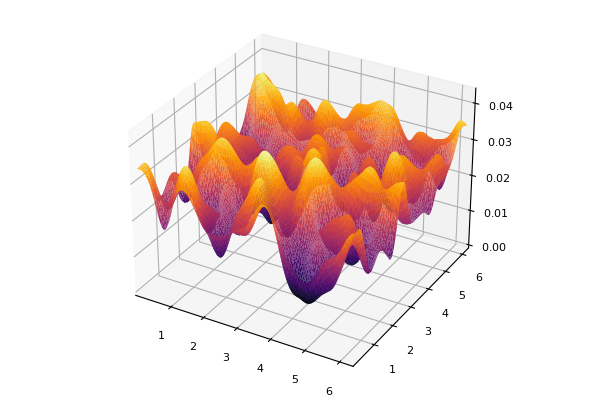

In [37]:
surface(grid[:,1], grid[:,2], initial_density; legend=false)
zlims!(0, maximum(initial_density)*1.1)

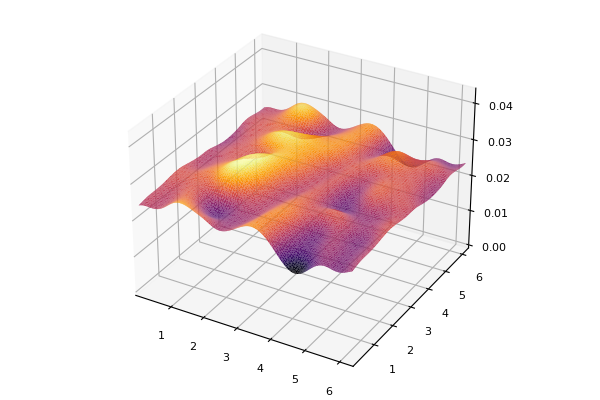

In [38]:
β1 = P * β;

evolved_density = basis_combination(grid, basis_locs, φ, ϵ, β1);
surface(grid[:,1], grid[:,2], evolved_density; legend=false)
zlims!(0, maximum(initial_density)*1.1)

In [39]:
integral = (2π)^2 * sum(evolved_density) / n_gridpoints;
println("Estimate of integral: $integral")

Estimate of integral: 0.9993913634819371


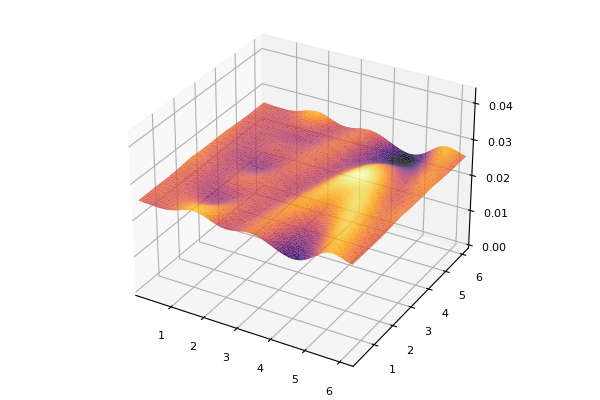

In [40]:
β2 = P * β1;

evolved_density = basis_combination(grid, basis_locs, φ, ϵ, β2);
surface(grid[:,1], grid[:,2], evolved_density; legend=false)
zlims!(0, maximum(initial_density)*1.1)

In [41]:
integral = (2π)^2 * sum(evolved_density) / n_gridpoints;
println("Estimate of integral: $integral")

Estimate of integral: 0.9994230645878548


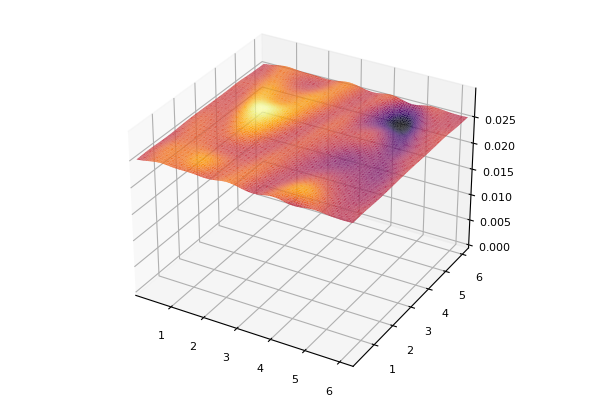

In [42]:
β3 = P * β2;

evolved_density = basis_combination(grid, basis_locs, φ, ϵ, β3);
surface(grid[:,1], grid[:,2], evolved_density; legend=false)
zlims!(0, maximum(evolved_density)*1.1)

In [43]:
integral = (2π)^2 * sum(evolved_density) / n_gridpoints;
println("Estimate of integral: $integral")

Estimate of integral: 0.9989240507955125


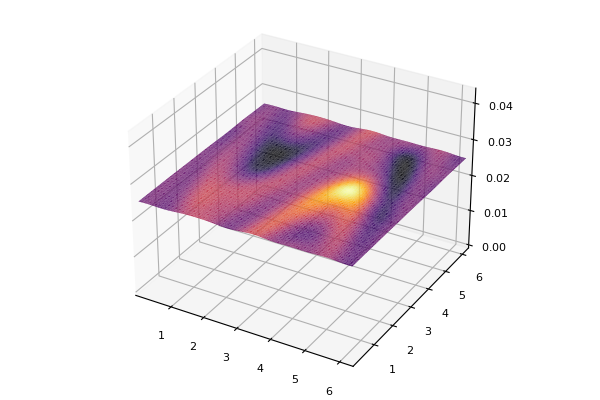

In [44]:
β4 = P * β3;

evolved_density = basis_combination(grid, basis_locs, φ, ϵ, β4);
surface(grid[:,1], grid[:,2], evolved_density; legend=false)
zlims!(0, maximum(initial_density)*1.1)

In [45]:
integral = (2π)^2 * sum(evolved_density) / n_gridpoints;
println("Estimate of integral: $integral")

Estimate of integral: 0.9986796790557045


After just four applications of $P$, we already see the limiting density start to emerge. Also, integrals are approximately preserved across each application.

In [46]:
println("Relevant constant function value: $(1/(range)^2)")
println("Mean evolved density surface value: $(mean(evolved_density))")

Relevant constant function value: 0.025330295910584444
Mean evolved density surface value: 0.0252968517903685


## Conclusions
We have a reasonably functional procedure. Now it is time to experiment with different model parameters.